In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

from sklearn.model_selection import KFold

np.random.seed(123)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/Xylan_full_passage.csv")
gLV_data.head()

,Treatments,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
0,COMM10<AC_passage1.0,0.0,0.002365,0.000840,0.000829,0.001313,0.000970,0.000679,0.000812,0.000646,0.001287,0.000257
1,COMM10<AC_passage1.0,24.0,0.014662,0.101607,0.000760,0.384594,0.277335,0.056530,0.001876,0.002736,0.089326,0.197074
2,COMM10<AC_passage2.0,0.0,0.000733,0.005080,0.000038,0.019230,0.013867,0.002826,0.000094,0.000137,0.004466,0.009854
3,COMM10<AC_passage2.0,24.0,0.011976,0.211938,0.000000,0.465521,0.168343,0.004875,0.003701,0.000000,0.023428,0.174718
4,COMM10<AC_passage3.0,0.0,0.000599,0.010597,0.000000,0.023276,0.008417,0.000244,0.000185,0.000000,0.001171,0.008736


In [3]:
# get species names
species = list(gLV_data.columns.values[2:])

# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def test(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)
    
    # save true values and predictions
    true = []
    pred = []
    stdv = []
    spcs = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])
        
        # predict end-point measured values
        output, output_stdv, _ = model.predict_latent(x_test, tspan)
        true.append(output_true[-1])
        pred.append(output[-1, :len(species)])
        stdv.append(output_stdv[-1, :len(species)])
        spcs.append(species)
        
    return np.concatenate(true), np.concatenate(pred), np.concatenate(stdv), np.concatenate(spcs)

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 3

# input to NN includes species, resources (and maybe also time) 
n_x = n_s + n_r

# dimension of hidden layer
n_h = 8

# normalizing constant for time as input
t_max = np.max(gLV_data.Time.values)

# log of death rate 
d = -3.*np.ones(n_s)

# map to hidden dimension
p_std = 1./np.sqrt(n_x)
W1 = p_std*np.random.randn(n_h, n_x)
b1 = np.random.randn(n_h)

# maximum consumption rate parameters
C = np.zeros([n_r, n_s]) 
C[1:,:] = -3.
C[2:,:] = -5.

# parameters to compute efficiency matrix
p_std = 1./np.sqrt(n_h)
W2 = p_std*np.random.randn(n_r+n_s, n_h) 
b2 = np.random.randn(n_r+n_s)

# concatenate parameter initial guess
params = np.concatenate((d, W1.flatten(), b1, C.flatten(), W2.flatten(), b2.flatten())) #, P.flatten()))

# set prior so that C is sparse 
W1prior = np.zeros_like(W1)
b1prior = np.zeros_like(b1)
Cprior = -5.*np.ones([n_r, n_s]) 
Pprior = -5.*np.ones([n_r, n_s])
W2prior = np.zeros_like(W2)
b2prior = np.zeros_like(b2)

# concatenate prior 
prior = np.concatenate((d, W1prior.flatten(), b1prior, Cprior.flatten(), W2prior.flatten(), b2prior.flatten()))#, Pprior.flatten()))

n_params = len(params)
n_params

269

In [6]:
C.T

array([[ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.]])

# Define model

In [7]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # compute state 
    state = jnp.concatenate((s, r))
    
    # death rate
    d = jnp.exp(params[:n_s])
    
    # map to hidden layer
    W1 = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b1 = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    h  = jnp.tanh(W1@state + b1)
    
    # maximum consumption rate parameters
    Cmax = jnp.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
    
    # attractiveness of resource i to species j / consumption efficiency
    W2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s:n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h], [n_r+n_s, n_h])
    b2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h:n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h+n_r+n_s], [n_r+n_s])
    f = jax.nn.sigmoid(W2@h + b2)
    
    # update Consumption matrix according to resource attractiveness 
    C = jnp.einsum("i,ij->ij", f[:n_r], Cmax)
    
    # production rate
    # P = jnp.exp(jnp.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h+n_r+n_s:], [n_r, n_s]))
    
    # rate of change of species 
    dsdt = s*(f[n_r:]*(C.T@r) - d)

    # rate of change of log of resources 
    dlrdt = -C@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [8]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

# K-fold cross-validation

In [9]:
# split dataframes according to treatment name 
mono_df = pd.concat([df for name, df in gLV_data.groupby("Treatments") if "Mono" in name])
dfs = [df for name, df in gLV_data.groupby("Treatments") if "Mono" not in name]

# set up Kfold object 
kf = KFold(n_splits=15, shuffle=True, random_state=123)

In [10]:
r0 = np.random.uniform(-3, 0, n_r)
print(r0)

# save true values, test predictions and uncertainty to a dataframe
kfold_df = pd.DataFrame()

for train_ind, test_ind in kf.split(dfs):
    
    # pull train and test data
    train_data = pd.concat([dfs[ind] for ind in train_ind])
    train_data = pd.concat([mono_df, train_data])
    
    # test data does not include mono culture
    test_data  = pd.concat([dfs[ind] for ind in test_ind])

    # fit model to training data
    model = ODE(system = system, 
                dataframe=train_data,
                C=O,
                CRparams = params, 
                r0 = r0,
                prior = prior,
                species = species,
                alpha_0 = 1e-5,
                f_ind = 1.,
                verbose=True)

    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, patience=1, max_fails=2)
    print("Elapsed time {:.2f}s".format(time.time()-t0))
    
    # test model 
    true, pred, stdv, spcs = test(model, test_data)
    
    # save results
    fold_df = pd.DataFrame()
    fold_df['True'] = true
    fold_df['Pred'] = pred
    fold_df['Stdv'] = stdv
    fold_df['Spcs'] = spcs
    kfold_df = pd.concat((kfold_df, fold_df))

[-1.20770067 -2.12054259 -1.10384852]
Updating precision...
Total samples: 3020, Updated regularization: 1.00e-05
Total weighted fitting error: 8.893
Total weighted fitting error: 6.218
Total weighted fitting error: 5.149
Total weighted fitting error: 4.749
Total weighted fitting error: 4.315
Total weighted fitting error: 4.142
Total weighted fitting error: 4.107
Total weighted fitting error: 4.039
Total weighted fitting error: 3.922
Total weighted fitting error: 3.877
Total weighted fitting error: 3.770
Total weighted fitting error: 3.633
Total weighted fitting error: 3.595
Total weighted fitting error: 3.521
Total weighted fitting error: 3.394
Total weighted fitting error: 3.373
Total weighted fitting error: 3.201
Total weighted fitting error: 3.182
Total weighted fitting error: 3.030
Total weighted fitting error: 3.017
Total weighted fitting error: 2.915
Total weighted fitting error: 2.836
Total weighted fitting error: 2.826
Total weighted fitting error: 2.730
Total weighted fitting

Evidence 9651.613
Pass count  1
Elapsed time 919.23s
Updating precision...
Total samples: 3080, Updated regularization: 1.00e-05
Total weighted fitting error: 9.018
Total weighted fitting error: 6.153
Total weighted fitting error: 5.288
Total weighted fitting error: 4.842
Total weighted fitting error: 4.408
Total weighted fitting error: 4.369
Total weighted fitting error: 4.300
Total weighted fitting error: 4.192
Total weighted fitting error: 4.136
Total weighted fitting error: 3.966
Total weighted fitting error: 3.890
Total weighted fitting error: 3.752
Total weighted fitting error: 3.713
Total weighted fitting error: 3.541
Total weighted fitting error: 3.509
Total weighted fitting error: 3.302
Total weighted fitting error: 3.210
Total weighted fitting error: 3.042
Total weighted fitting error: 2.990
Total weighted fitting error: 2.893
Total weighted fitting error: 2.743
Total weighted fitting error: 2.715
Total weighted fitting error: 2.661
Total weighted fitting error: 2.567
Total w

Total weighted fitting error: 1.969
Total weighted fitting error: 1.958
Total weighted fitting error: 1.893
Total weighted fitting error: 1.863
Total weighted fitting error: 1.858
Total weighted fitting error: 1.853
Total weighted fitting error: 1.808
Total weighted fitting error: 1.806
Total weighted fitting error: 1.789
Total weighted fitting error: 1.783
Total weighted fitting error: 1.781
Total weighted fitting error: 1.760
Total weighted fitting error: 1.760
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.760309978559575
       x: [ 2.295e+00 -1.710e+00 ... -1.799e+00 -1.510e+00]
     nit: 60
     jac: [-3.447e-02 -3.325e-04 ...  2.010e-02 -4.230e-03]
    nfev: 86
    njev: 86
    nhev: 60
Evidence -469.321
Updating precision...
Total samples: 3080, Updated regularization: 1.17e-06
Total weighted fitting error: 37.806
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 37.806310717396464
       x: [ 2.295e+00 

Total weighted fitting error: 1.969
Total weighted fitting error: 1.910
Total weighted fitting error: 1.905
Total weighted fitting error: 1.901
Total weighted fitting error: 1.895
Total weighted fitting error: 1.853
Total weighted fitting error: 1.850
Total weighted fitting error: 1.849
Total weighted fitting error: 1.792
Total weighted fitting error: 1.787
Total weighted fitting error: 1.786
Total weighted fitting error: 1.775
Total weighted fitting error: 1.720
Total weighted fitting error: 1.711
Total weighted fitting error: 1.711
Total weighted fitting error: 1.706
Total weighted fitting error: 1.667
Total weighted fitting error: 1.663
Total weighted fitting error: 1.662
Total weighted fitting error: 1.656
Total weighted fitting error: 1.617
Total weighted fitting error: 1.613
Total weighted fitting error: 1.613
Total weighted fitting error: 1.611
Total weighted fitting error: 1.574
Total weighted fitting error: 1.567
Total weighted fitting error: 1.565
Total weighted fitting error

Total samples: 3080, Updated regularization: 1.49e-06
Total weighted fitting error: 33.454
Total weighted fitting error: 32.431
Total weighted fitting error: 32.409
Total weighted fitting error: 32.374
Total weighted fitting error: 31.052
Total weighted fitting error: 30.817
Total weighted fitting error: 30.771
Total weighted fitting error: 30.689
Total weighted fitting error: 29.953
Total weighted fitting error: 29.922
Total weighted fitting error: 29.894
Total weighted fitting error: 29.340
Total weighted fitting error: 29.272
Total weighted fitting error: 29.235
Total weighted fitting error: 28.492
Total weighted fitting error: 28.425
Total weighted fitting error: 28.368
Total weighted fitting error: 27.878
Total weighted fitting error: 27.854
Total weighted fitting error: 27.187
Total weighted fitting error: 26.892
Total weighted fitting error: 26.787
Total weighted fitting error: 26.593
Total weighted fitting error: 25.859
Total weighted fitting error: 25.749
Total weighted fittin

Total weighted fitting error: 1.946
Total weighted fitting error: 1.888
Total weighted fitting error: 1.881
Total weighted fitting error: 1.879
Total weighted fitting error: 1.836
Total weighted fitting error: 1.835
Total weighted fitting error: 1.826
Total weighted fitting error: 1.780
Total weighted fitting error: 1.775
Total weighted fitting error: 1.772
Total weighted fitting error: 1.766
Total weighted fitting error: 1.709
Total weighted fitting error: 1.706
Total weighted fitting error: 1.705
Total weighted fitting error: 1.668
Total weighted fitting error: 1.659
Total weighted fitting error: 1.653
Total weighted fitting error: 1.643
Total weighted fitting error: 1.634
Total weighted fitting error: 1.634
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.6342543464465746
       x: [ 2.371e+00 -1.431e+00 ... -1.794e+00 -1.529e+00]
     nit: 76
     jac: [ 1.974e-02 -6.666e-03 ...  1.358e-02 -1.782e-02]
    nfev: 118
    njev: 118
    nhev: 76
Ev

Total weighted fitting error: 1.896
Total weighted fitting error: 1.889
Total weighted fitting error: 1.836
Total weighted fitting error: 1.831
Total weighted fitting error: 1.829
Total weighted fitting error: 1.783
Total weighted fitting error: 1.772
Total weighted fitting error: 1.771
Total weighted fitting error: 1.757
Total weighted fitting error: 1.749
Total weighted fitting error: 1.688
Total weighted fitting error: 1.681
Total weighted fitting error: 1.679
Total weighted fitting error: 1.678
Total weighted fitting error: 1.666
Total weighted fitting error: 1.664
Total weighted fitting error: 1.663
Total weighted fitting error: 1.662
Total weighted fitting error: 1.653
Total weighted fitting error: 1.652
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.6523360781872127
       x: [ 2.303e+00 -1.627e+00 ... -1.756e+00 -1.342e+00]
     nit: 69
     jac: [-8.046e-02 -2.327e-03 ...  3.501e-02 -1.476e-03]
    nfev: 104
    njev: 104
    nhev: 69
Ev

Total weighted fitting error: 2.150
Total weighted fitting error: 2.109
Total weighted fitting error: 2.051
Total weighted fitting error: 2.043
Total weighted fitting error: 2.040
Total weighted fitting error: 2.017
Total weighted fitting error: 2.016
Total weighted fitting error: 1.959
Total weighted fitting error: 1.955
Total weighted fitting error: 1.919
Total weighted fitting error: 1.913
Total weighted fitting error: 1.856
Total weighted fitting error: 1.853
Total weighted fitting error: 1.848
Total weighted fitting error: 1.803
Total weighted fitting error: 1.801
Total weighted fitting error: 1.798
Total weighted fitting error: 1.766
Total weighted fitting error: 1.764
Total weighted fitting error: 1.709
Total weighted fitting error: 1.702
Total weighted fitting error: 1.699
Total weighted fitting error: 1.678
Total weighted fitting error: 1.675
Total weighted fitting error: 1.648
Total weighted fitting error: 1.647
Total weighted fitting error: 1.647
Total weighted fitting error

Total weighted fitting error: 1.775
Total weighted fitting error: 1.730
Total weighted fitting error: 1.725
Total weighted fitting error: 1.724
Total weighted fitting error: 1.711
Total weighted fitting error: 1.709
Total weighted fitting error: 1.667
Total weighted fitting error: 1.661
Total weighted fitting error: 1.661
Total weighted fitting error: 1.617
Total weighted fitting error: 1.611
Total weighted fitting error: 1.609
Total weighted fitting error: 1.606
Total weighted fitting error: 1.592
Total weighted fitting error: 1.584
Total weighted fitting error: 1.582
Total weighted fitting error: 1.565
Total weighted fitting error: 1.565
Total weighted fitting error: 1.544
Total weighted fitting error: 1.534
Total weighted fitting error: 1.529
Total weighted fitting error: 1.528
Total weighted fitting error: 1.526
Total weighted fitting error: 1.523
Total weighted fitting error: 1.507
Total weighted fitting error: 1.506
Total weighted fitting error: 1.505
Total weighted fitting error

Total weighted fitting error: 1.537
Total weighted fitting error: 1.533
Total weighted fitting error: 1.497
Total weighted fitting error: 1.494
Total weighted fitting error: 1.492
Total weighted fitting error: 1.478
Total weighted fitting error: 1.477
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.4774310987514643
       x: [ 2.437e+00 -1.661e+00 ... -1.759e+00 -1.604e+00]
     nit: 66
     jac: [-1.349e-02 -8.157e-03 ...  5.666e-03  2.041e-03]
    nfev: 99
    njev: 99
    nhev: 66
Evidence -493.751
Updating precision...
Total samples: 3040, Updated regularization: 1.33e-06
Total weighted fitting error: 25.448
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 25.447956154168825
       x: [ 2.437e+00 -1.661e+00 ... -1.759e+00 -1.604e+00]
     nit: 1
     jac: [ 1.333e+00  2.148e-01 ...  3.031e-01 -1.682e-01]
    nfev: 2
    njev: 2
    nhev: 1
Hessian not positive definite, increasing regularization...
Evidence 

Total weighted fitting error: 29.106
Total weighted fitting error: 29.089
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 29.089091193961877
       x: [ 2.512e+00 -1.579e+00 ... -1.915e+00 -1.757e+00]
     nit: 4
     jac: [-3.477e+00 -1.577e-01 ...  1.364e+00 -2.836e-01]
    nfev: 7
    njev: 7
    nhev: 4
Hessian not positive definite, increasing regularization...
Evidence 4069.045
Updating precision...
Total samples: 3080, Updated regularization: 5.65e-07
Total weighted fitting error: 370.107
Total weighted fitting error: 363.842
Total weighted fitting error: 363.645
Total weighted fitting error: 363.288
Total weighted fitting error: 362.639
Total weighted fitting error: 358.547
Total weighted fitting error: 357.320
Total weighted fitting error: 357.019
Total weighted fitting error: 356.594
Total weighted fitting error: 355.805
Total weighted fitting error: 352.093
Total weighted fitting error: 351.830
 message: Optimization terminated successful

Hessian not positive definite, increasing regularization...
Evidence 7976.461
Updating precision...
Total samples: 3040, Updated regularization: 1.48e-06
Total weighted fitting error: 1257.973
Total weighted fitting error: 1255.582
Total weighted fitting error: 1254.356
Total weighted fitting error: 1245.015
Total weighted fitting error: 1242.552
Total weighted fitting error: 1241.782
Total weighted fitting error: 1226.177
Total weighted fitting error: 1223.875
Total weighted fitting error: 1221.808
Total weighted fitting error: 1201.868
Total weighted fitting error: 1201.103
Total weighted fitting error: 1199.713
Total weighted fitting error: 1164.708
Total weighted fitting error: 1145.496
Total weighted fitting error: 1120.842
Total weighted fitting error: 1116.654
Total weighted fitting error: 1086.023
Total weighted fitting error: 1084.778
Total weighted fitting error: 1073.914
Total weighted fitting error: 1072.623
Total weighted fitting error: 1061.645
Total weighted fitting erro

Total weighted fitting error: 446.670
Total weighted fitting error: 446.412
Total weighted fitting error: 437.754
Total weighted fitting error: 434.333
Total weighted fitting error: 433.707
Total weighted fitting error: 432.965
Total weighted fitting error: 425.761
Total weighted fitting error: 416.711
Total weighted fitting error: 416.096
Total weighted fitting error: 388.320
Total weighted fitting error: 386.094
Total weighted fitting error: 385.034
Total weighted fitting error: 383.295
Total weighted fitting error: 380.881
Total weighted fitting error: 376.677
Total weighted fitting error: 376.645
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 376.64498733019735
       x: [ 2.243e+00 -1.401e+00 ... -1.851e+00 -1.478e+00]
     nit: 17
     jac: [-2.959e+01 -2.172e+00 ...  1.066e+01 -7.490e+00]
    nfev: 24
    njev: 24
    nhev: 17
Hessian not positive definite, increasing regularization...
Evidence 7976.501
Updating precision...
Total samples: 3

Hessian not positive definite, increasing regularization...
Evidence 4103.047
Updating precision...
Total samples: 3090, Updated regularization: 1.11e-06
Total weighted fitting error: 360.350
Total weighted fitting error: 359.950
Total weighted fitting error: 356.422
Total weighted fitting error: 356.290
Total weighted fitting error: 356.105
Total weighted fitting error: 351.878
Total weighted fitting error: 351.397
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 351.39710218693796
       x: [ 2.793e+00 -1.525e+00 ... -2.086e+00 -2.104e+00]
     nit: 7
     jac: [-1.007e+02  3.358e+00 ...  2.662e+01 -9.734e+00]
    nfev: 12
    njev: 12
    nhev: 7
Hessian not positive definite, increasing regularization...
Evidence 7923.782
Updating precision...
Total samples: 3090, Updated regularization: 1.16e-06
Total weighted fitting error: 1132.310
Total weighted fitting error: 1132.117
 message: Optimization terminated successfully.
 success: True
  status: 0

Total weighted fitting error: 335.361
Total weighted fitting error: 335.248
Total weighted fitting error: 330.983
Total weighted fitting error: 330.818
Total weighted fitting error: 329.317
Total weighted fitting error: 329.124
Total weighted fitting error: 324.760
Total weighted fitting error: 322.427
Total weighted fitting error: 322.174
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 322.1735503842456
       x: [ 2.620e+00 -1.481e+00 ... -1.875e+00 -1.947e+00]
     nit: 20
     jac: [-7.038e+01  1.332e+00 ... -1.201e+01 -5.067e+00]
    nfev: 39
    njev: 39
    nhev: 20
Hessian not positive definite, increasing regularization...
Evidence 7836.111
Updating precision...
Total samples: 3050, Updated regularization: 1.85e-06
Total weighted fitting error: 1127.129
Total weighted fitting error: 1123.845
Total weighted fitting error: 1117.845
Total weighted fitting error: 1106.702
Total weighted fitting error: 1106.614
 message: Optimization terminated 

In [13]:
kfold_df.to_csv("kfold/CRNN_kfold_fiber.csv", index=False)
kfold_df

,True,Pred,Stdv,Spcs
0,0.010416,0.016189,0.028149,S1
1,0.116792,0.151506,0.030795,S2
2,0.002013,0.000059,0.027926,S3
3,0.203811,0.231267,0.036432,S4
4,0.142743,0.274974,0.032699,S5
...,...,...,...,...
55,0.000000,0.000000,0.030369,S6
56,0.017377,0.053005,0.032594,S7
57,0.053563,0.052170,0.031248,S8
58,0.008348,0.184620,0.037910,S9


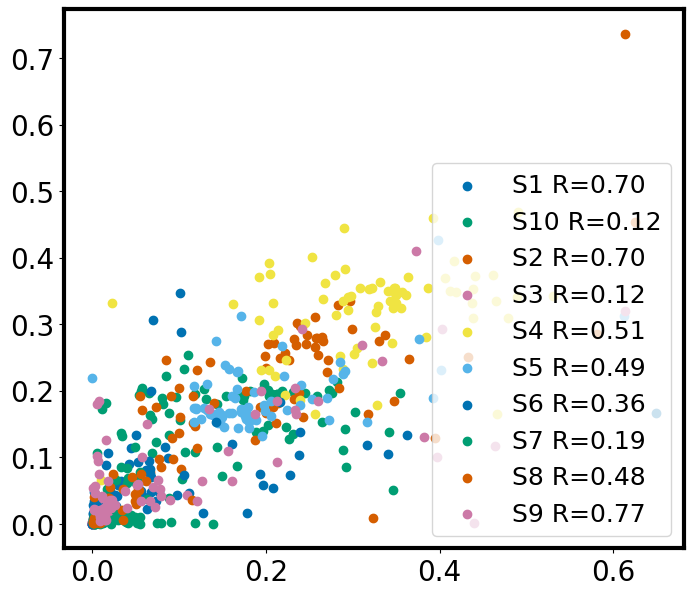

In [14]:
true = kfold_df['True'].values
pred = kfold_df['Pred'].values
stdv = kfold_df['Stdv'].values
spcs = kfold_df['Spcs'].values

for i,sp in enumerate(np.unique(spcs)):
    sp_inds = spcs == sp
    inds_pos = true[sp_inds] > 0
    
    R = linregress(true[sp_inds][inds_pos], pred[sp_inds][inds_pos]).rvalue
    plt.scatter(true[sp_inds][inds_pos], pred[sp_inds][inds_pos], c=f"C{i}", label=sp + " R={:.2f}".format(R))
plt.legend(loc="lower right")
plt.savefig("kfold/CRNN_kfold_fiber.pdf")
plt.show()